# Las Vegas Short-Term Rental Investment Analysis

In [4]:
# Section 1: Setup & Imports
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [5]:
# Section 2: Data Import

# Load Airbnb data
listings = pd.read_csv('listings.csv.gz', compression='gzip')
calendar = pd.read_csv('calendar.csv.gz', compression='gzip')
neighbourhoods = pd.read_csv('neighbourhoods.csv')

# Check what we loaded
print("Listings:", listings.shape)
print("Calendar:", calendar.shape)
print("Neighbourhoods:", neighbourhoods.shape)

Listings: (17624, 79)
Calendar: (6432761, 7)
Neighbourhoods: (7, 2)


In [6]:
# Load MLS home sales data
mls_1bed = pd.read_csv('mls_1bed_6mo.csv')
mls_2bed = pd.read_csv('mls_2bed_500kmax_3mo.csv')
mls_3bed = pd.read_csv('mls_3bed_500kmax_3mo.csv')
mls_4bed = pd.read_csv('mls_4bed_500kmax_3mo.csv')
mls_5bed = pd.read_csv('mls_5bed_667kmax_3mo.csv')
mls_6bed = pd.read_csv('mls_6bed_868kmax_3mo.csv')

# Combine into one dataframe
mls = pd.concat([mls_1bed, mls_2bed, mls_3bed, mls_4bed, mls_5bed, mls_6bed], ignore_index=True)

print("MLS:", mls.shape)

MLS: (2990, 18)


In [7]:
# Section 3: Data Cleaning

# Clean listings price (remove $ and convert to number)
listings['price_clean'] = listings['price'].str.replace('$', '').str.replace(',', '').astype(float)

# Remove outliers (keep $10 - $1000 per night)
listings_clean = listings[(listings['price_clean'] >= 10) & (listings['price_clean'] <= 1000)]

print("Listings before cleaning:", len(listings))
print("Listings after cleaning:", len(listings_clean))

Listings before cleaning: 17624
Listings after cleaning: 11833


In [8]:
# Clean MLS price (remove $ and convert to number)
mls['price_clean'] = mls['Current Price'].str.replace('$', '').str.replace(',', '').astype(float)

# Clean square footage
mls['sqft'] = mls['Approx Liv Area'].str.replace(',', '').astype(float)

print("MLS price range: ${:,.0f} to ${:,.0f}".format(mls['price_clean'].min(), mls['price_clean'].max()))

MLS price range: $61,750 to $850,000


In [9]:
# Calculate occupancy rate per listing
# 'f' means unavailable (booked), 't' means available
occupancy = calendar.groupby('listing_id')['available'].apply(lambda x: (x == 'f').mean())
occupancy = occupancy.reset_index()
occupancy.columns = ['id', 'occupancy_rate']

print("Occupancy rates calculated for", len(occupancy), "listings")
print("Average occupancy:", round(occupancy['occupancy_rate'].mean() * 100, 1), "%")

Occupancy rates calculated for 17624 listings
Average occupancy: 45.3 %


In [10]:
# Merge occupancy with listings
listings_full = listings_clean.merge(occupancy, on='id')

# Calculate annual revenue (ADR x Occupancy x 365)
listings_full['annual_revenue'] = listings_full['price_clean'] * listings_full['occupancy_rate'] * 365

print("Listings with revenue:", len(listings_full))
print("Average annual revenue: ${:,.0f}".format(listings_full['annual_revenue'].mean()))

Listings with revenue: 11833
Average annual revenue: $25,828


In [11]:
# Section 4: Database Creation

# Create SQLite database (saved to file)
conn = sqlite3.connect('vegas_airbnb.db')

# Store dataframes as SQL tables
listings_full.to_sql('listings', conn, index=False, if_exists='replace')
mls.to_sql('mls', conn, index=False, if_exists='replace')
neighbourhoods.to_sql('neighbourhoods', conn, index=False, if_exists='replace')

print("Database saved: vegas_airbnb.db")
print("Tables created: listings, mls, neighbourhoods")

Database saved: vegas_airbnb.db
Tables created: listings, mls, neighbourhoods


In [12]:
# Test SQL query
query = """
SELECT 
    room_type, 
    COUNT(*) as count, 
    ROUND(AVG(annual_revenue), 0) as avg_revenue
FROM listings
GROUP BY room_type
ORDER BY avg_revenue DESC
"""

pd.read_sql(query, conn)

,room_type,count,avg_revenue
0,Entire home/apt,8699,28235.0
1,Hotel room,151,24325.0
2,Private room,2903,19206.0
3,Shared room,80,7219.0


## Section 5: Analysis

In [14]:
# Revenue by neighbourhood
query = """
SELECT neighbourhood_cleansed as neighbourhood,
       COUNT(*) as listings,
       ROUND(AVG(price_clean), 0) as avg_adr,
       ROUND(AVG(occupancy_rate), 2) as avg_occupancy,
       ROUND(AVG(annual_revenue), 0) as avg_revenue
FROM listings
GROUP BY neighbourhood_cleansed
ORDER BY avg_revenue DESC
"""

pd.read_sql(query, conn)

,neighbourhood,listings,avg_adr,avg_occupancy,avg_revenue
0,Unincorporated Areas,8662,189.0,0.42,28763.0
1,City of Henderson,678,198.0,0.28,19418.0
2,City of North Las Vegas,649,164.0,0.33,18692.0
3,Boulder City,13,131.0,0.38,17507.0
4,City of Las Vegas,1715,151.0,0.32,17080.0
5,City of Mesquite,110,174.0,0.24,14890.0
6,Nellis AFB,6,92.0,0.11,4778.0


In [15]:
# Revenue by bedrooms (Unincorporated Areas only - most data)
query = """
SELECT bedrooms,
       COUNT(*) as listings,
       ROUND(AVG(price_clean), 0) as avg_adr,
       ROUND(AVG(occupancy_rate), 2) as avg_occupancy,
       ROUND(AVG(annual_revenue), 0) as avg_revenue
FROM listings
WHERE neighbourhood_cleansed = 'Unincorporated Areas'
  AND bedrooms BETWEEN 1 AND 6
GROUP BY bedrooms
ORDER BY bedrooms
"""

pd.read_sql(query, conn)

,bedrooms,listings,avg_adr,avg_occupancy,avg_revenue
0,1.0,3869,135.0,0.42,21065.0
1,2.0,1626,221.0,0.45,35746.0
2,3.0,976,205.0,0.45,33033.0
3,4.0,775,250.0,0.40,34983.0
4,5.0,458,339.0,0.41,48035.0
5,6.0,121,444.0,0.37,62479.0


In [16]:
# get MLS home prices

# Home prices by bedrooms from MLS
query = """
SELECT "Beds Total" as bedrooms,
       COUNT(*) as homes_sold,
       ROUND(AVG(price_clean), 0) as avg_price,
       ROUND(MIN(price_clean), 0) as min_price,
       ROUND(MAX(price_clean), 0) as max_price
FROM mls
GROUP BY "Beds Total"
ORDER BY bedrooms
"""

pd.read_sql(query, conn)

,bedrooms,homes_sold,avg_price,min_price,max_price
0,1,18,277504.0,80000.0,734573.0
1,2,314,361188.0,121000.0,500000.0
2,3,1636,403568.0,107800.0,500000.0
3,4,730,425455.0,61750.0,500000.0
4,5,245,524622.0,215000.0,660000.0
5,6,47,667422.0,310000.0,850000.0


In [17]:
# ROI Analysis: Combine Airbnb revenue with home prices
query = """
SELECT 
    a.bedrooms,
    a.listings as airbnb_listings,
    a.avg_revenue as airbnb_revenue,
    m.homes_sold,
    m.avg_price as home_price,
    ROUND(m.avg_price * 0.072, 0) as annual_mortgage,
    ROUND(a.avg_revenue - (m.avg_price * 0.072), 0) as net_income,
    ROUND(((a.avg_revenue - (m.avg_price * 0.072)) / m.avg_price) * 100, 2) as roi_percent
FROM (
    SELECT bedrooms,
           COUNT(*) as listings,
           AVG(annual_revenue) as avg_revenue
    FROM listings
    WHERE neighbourhood_cleansed = 'Unincorporated Areas'
      AND bedrooms BETWEEN 1 AND 6
    GROUP BY bedrooms
) a
INNER JOIN (
    SELECT "Beds Total" as bedrooms,
           COUNT(*) as homes_sold,
           AVG(price_clean) as avg_price
    FROM mls
    GROUP BY "Beds Total"
) m ON a.bedrooms = m.bedrooms
ORDER BY roi_percent DESC
"""

roi_analysis = pd.read_sql(query, conn)
roi_analysis

,bedrooms,airbnb_listings,airbnb_revenue,homes_sold,home_price,annual_mortgage,net_income,roi_percent
0,2.0,1626,35746.186962,314,361188.140127,26006.0,9741.0,2.70
1,6.0,121,62479.173554,47,667421.808511,48054.0,14425.0,2.16
2,5.0,458,48035.080786,245,524621.771429,37773.0,10262.0,1.96
3,4.0,775,34983.344516,730,425454.747945,30633.0,4351.0,1.02
4,3.0,976,33032.846311,1636,403567.984719,29057.0,3976.0,0.99
5,1.0,3869,21065.264926,18,277504.055556,19980.0,1085.0,0.39


In [18]:
# Top performer analysis (75th percentile revenue) using python because sqllite can't do percentile

top_performers = listings_full[
    (listings_full['neighbourhood_cleansed'] == 'Unincorporated Areas') &
    (listings_full['bedrooms'].between(1, 6))
].groupby('bedrooms')['annual_revenue'].quantile(0.75)

print("75th Percentile Revenue by Bedrooms:")
print(top_performers.round(0))

75th Percentile Revenue by Bedrooms:
bedrooms
1.0    27664.0
2.0    50322.0
3.0    42685.0
4.0    50946.0
5.0    65182.0
6.0    92225.0
Name: annual_revenue, dtype: float64


In [19]:
# ROI Analysis with top performer (75th percentile) revenue
top_performers = listings_full[
    (listings_full['neighbourhood_cleansed'] == 'Unincorporated Areas') &
    (listings_full['bedrooms'].between(1, 6))
].groupby('bedrooms')['annual_revenue'].quantile(0.75).reset_index()
top_performers.columns = ['bedrooms', 'top_revenue']

# Get MLS prices
mls_prices = mls.groupby('Beds Total')['price_clean'].mean().reset_index()
mls_prices.columns = ['bedrooms', 'home_price']

# Merge and calculate ROI
roi = top_performers.merge(mls_prices, on='bedrooms')
roi['annual_mortgage'] = roi['home_price'] * 0.06
roi['net_income'] = roi['top_revenue'] - roi['annual_mortgage']
roi['roi_percent'] = (roi['net_income'] / roi['home_price']) * 100

roi.round(0)

,bedrooms,top_revenue,home_price,annual_mortgage,net_income,roi_percent
0,1.0,27664.0,277504.0,16650.0,11014.0,4.0
1,2.0,50322.0,361188.0,21671.0,28650.0,8.0
2,3.0,42685.0,403568.0,24214.0,18471.0,5.0
3,4.0,50946.0,425455.0,25527.0,25418.0,6.0
4,5.0,65182.0,524622.0,31477.0,33705.0,6.0
5,6.0,92225.0,667422.0,40045.0,52180.0,8.0


In [20]:
# Save top performer revenue to database (75th and 90th percentile)
airbnb_filtered = listings_full[
    (listings_full['neighbourhood_cleansed'] == 'Unincorporated Areas') &
    (listings_full['bedrooms'].between(1, 6))
]

# 75th percentile (good operators)
top_75 = airbnb_filtered.groupby('bedrooms')['annual_revenue'].quantile(0.75).reset_index()
top_75.columns = ['bedrooms', 'revenue_75th']

# 90th percentile (excellent operators)
top_90 = airbnb_filtered.groupby('bedrooms')['annual_revenue'].quantile(0.90).reset_index()
top_90.columns = ['bedrooms', 'revenue_90th']

# Merge and save
top_performers = top_75.merge(top_90, on='bedrooms')
top_performers.to_sql('top_performers', conn, index=False, if_exists='replace')

print("Table created: top_performers")
print(top_performers.round(0))

Table created: top_performers
   bedrooms  revenue_75th  revenue_90th
0       1.0       27664.0       54612.0
1       2.0       50322.0       86625.0
2       3.0       42685.0       66386.0
3       4.0       50946.0       73412.0
4       5.0       65182.0      107831.0
5       6.0       92225.0      148000.0


In [21]:
# ROI Analysis in SQL
query = """
SELECT 
    t.bedrooms,
    ROUND(t.revenue_75th, 0) as revenue_75th,
    ROUND(t.revenue_90th, 0) as revenue_90th,
    ROUND(m.avg_price, 0) as home_price,
    ROUND(m.avg_price * 0.06, 0) as annual_mortgage,
    ROUND(t.revenue_75th - (m.avg_price * 0.06), 0) as net_income_75th,
    ROUND(t.revenue_90th - (m.avg_price * 0.06), 0) as net_income_90th,
    ROUND(((t.revenue_75th - (m.avg_price * 0.06)) / m.avg_price) * 100, 2) as roi_75th,
    ROUND(((t.revenue_90th - (m.avg_price * 0.06)) / m.avg_price) * 100, 2) as roi_90th
FROM top_performers t
JOIN (
    SELECT "Beds Total" as bedrooms, AVG(price_clean) as avg_price
    FROM mls
    GROUP BY "Beds Total"
) m ON t.bedrooms = m.bedrooms
ORDER BY roi_90th DESC
"""

roi_analysis = pd.read_sql(query, conn)
roi_analysis

,bedrooms,revenue_75th,revenue_90th,home_price,annual_mortgage,net_income_75th,net_income_90th,roi_75th,roi_90th
0,2.0,50322.0,86625.0,361188.0,21671.0,28650.0,64954.0,7.93,17.98
1,6.0,92225.0,148000.0,667422.0,40045.0,52180.0,107955.0,7.82,16.17
2,5.0,65182.0,107831.0,524622.0,31477.0,33705.0,76353.0,6.42,14.55
3,1.0,27664.0,54612.0,277504.0,16650.0,11014.0,37962.0,3.97,13.68
4,4.0,50946.0,73412.0,425455.0,25527.0,25418.0,47885.0,5.97,11.25
5,3.0,42685.0,66386.0,403568.0,24214.0,18471.0,42172.0,4.58,10.45


## Section 6: Visualizations

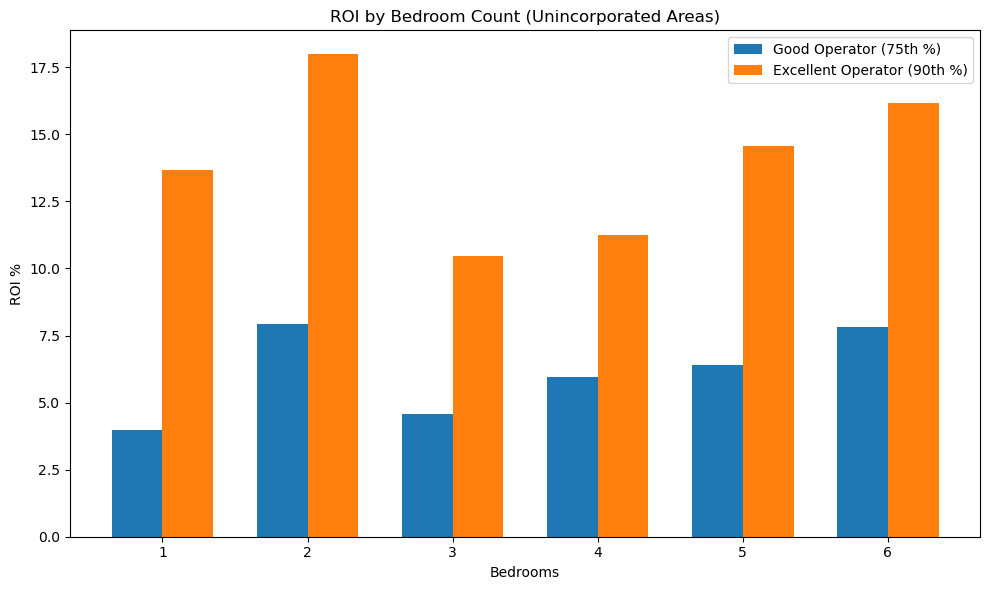

In [23]:
# ROI Comparison Chart
fig, ax = plt.subplots(figsize=(10, 6))

x = roi_analysis['bedrooms']
width = 0.35

bars1 = ax.bar(x - width/2, roi_analysis['roi_75th'], width, label='Good Operator (75th %)')
bars2 = ax.bar(x + width/2, roi_analysis['roi_90th'], width, label='Excellent Operator (90th %)')

ax.set_xlabel('Bedrooms')
ax.set_ylabel('ROI %')
ax.set_title('ROI by Bedroom Count (Unincorporated Areas)')
ax.legend()

plt.tight_layout()
plt.savefig('roi_by_bedroom.png')
plt.show()

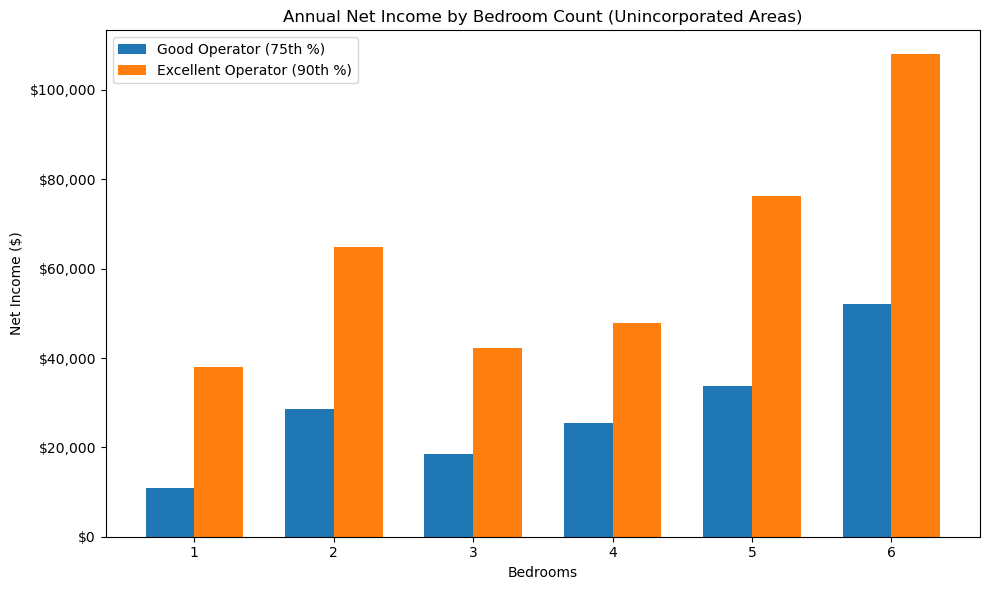

In [24]:
# Net Income Comparison Chart
fig, ax = plt.subplots(figsize=(10, 6))

x = roi_analysis['bedrooms']
width = 0.35

bars1 = ax.bar(x - width/2, roi_analysis['net_income_75th'], width, label='Good Operator (75th %)')
bars2 = ax.bar(x + width/2, roi_analysis['net_income_90th'], width, label='Excellent Operator (90th %)')

ax.set_xlabel('Bedrooms')
ax.set_ylabel('Net Income ($)')
ax.set_title('Annual Net Income by Bedroom Count (Unincorporated Areas)')
ax.legend()

# Format y-axis as dollars
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.savefig('roi_by_bedroom.png')
plt.show()

In [25]:
# Check amenities column
listings_full['amenities'].head(3)

0    ["Kitchen", "Essentials", "Iron", "TV with sta...
1    ["Hot water", "Kitchen", "Essentials", "Iron",...
2    ["Washer", "Kitchen", "TV with standard cable"...
Name: amenities, dtype: object

In [26]:
# Parse amenities and find most common
import ast

# Convert string to actual list
listings_full['amenities_list'] = listings_full['amenities'].apply(ast.literal_eval)

# Count each amenity
amenity_counts = {}
for amenities in listings_full['amenities_list']:
    for a in amenities:
        amenity_counts[a] = amenity_counts.get(a, 0) + 1

# Top 20 amenities
top_amenities = sorted(amenity_counts.items(), key=lambda x: x[1], reverse=True)[:20]
for amenity, count in top_amenities:
    print(f"{amenity}: {count}")

Smoke alarm: 11312
Wifi: 11128
Kitchen: 10159
Hot water: 9638
Hair dryer: 9443
Free parking on premises: 9296
Iron: 9208
Hangers: 9091
Carbon monoxide alarm: 9065
Microwave: 8771
Air conditioning: 8760
Essentials: 8741
Dishes and silverware: 8646
Self check-in: 8643
Bed linens: 8589
Shampoo: 8549
Fire extinguisher: 8488
TV: 8075
Cooking basics: 7977
Refrigerator: 7885


In [27]:
# Define high-value amenities to search for
high_value = ['pool', 'hot tub', 'jacuzzi', 'spa', 'game', 'theater', 'theatre', 
              'view', 'gym', 'sauna', 'bbq', 'grill', 'arcade', 'billiard', 
              'pool table', 'golf', 'fire pit', 'outdoor kitchen']

# Check if listing has each high-value amenity
def has_amenity(amenities_list, keyword):
    return any(keyword.lower() in a.lower() for a in amenities_list)

# Create columns for each high-value amenity
for amenity in high_value:
    col_name = amenity.replace(' ', '_')
    listings_full[col_name] = listings_full['amenities_list'].apply(lambda x: has_amenity(x, amenity))

# Check pool impact on revenue
pool_comparison = listings_full.groupby('pool')['annual_revenue'].mean()
print("Pool impact on revenue:")
print(pool_comparison.round(0))

Pool impact on revenue:
pool
False    16410.0
True     31685.0
Name: annual_revenue, dtype: float64


In [28]:
# Compare revenue for each high-value amenity
print("Revenue Impact by Amenity:\n")
print(f"{'Amenity':<20} {'Without':>12} {'With':>12} {'Difference':>12} {'% Lift':>10}")
print("-" * 70)

for amenity in high_value:
    col_name = amenity.replace(' ', '_')
    without = listings_full[listings_full[col_name] == False]['annual_revenue'].mean()
    with_amenity = listings_full[listings_full[col_name] == True]['annual_revenue'].mean()
    diff = with_amenity - without
    pct_lift = (diff / without) * 100
    
    print(f"{amenity:<20} ${without:>10,.0f} ${with_amenity:>10,.0f} ${diff:>10,.0f} {pct_lift:>9.1f}%")

Revenue Impact by Amenity:

Amenity                   Without         With   Difference     % Lift
----------------------------------------------------------------------
pool                 $    16,410 $    31,685 $    15,274      93.1%
hot tub              $    20,266 $    33,940 $    13,674      67.5%
jacuzzi              $    25,828 $       nan $       nan       nan%
spa                  $    25,197 $    26,154 $       957       3.8%
game                 $    24,399 $    32,539 $     8,140      33.4%
theater              $    25,585 $    37,432 $    11,847      46.3%
theatre              $    25,828 $       nan $       nan       nan%
view                 $    25,887 $    25,589 $      -298      -1.2%
gym                  $    24,185 $    30,087 $     5,902      24.4%
sauna                $    24,993 $    45,214 $    20,221      80.9%
bbq                  $    23,310 $    29,669 $     6,359      27.3%
grill                $    23,311 $    29,665 $     6,354      27.3%
arcade        

In [29]:
# Create clean amenity impact table (remove nan values)
amenity_impact = []

for amenity in high_value:
    col_name = amenity.replace(' ', '_')
    with_count = listings_full[col_name].sum()
    
    if with_count > 0:  # Only include if amenity exists
        without = listings_full[listings_full[col_name] == False]['annual_revenue'].mean()
        with_amenity = listings_full[listings_full[col_name] == True]['annual_revenue'].mean()
        diff = with_amenity - without
        pct_lift = (diff / without) * 100
        
        amenity_impact.append({
            'amenity': amenity,
            'listings_with': int(with_count),
            'revenue_without': round(without, 0),
            'revenue_with': round(with_amenity, 0),
            'revenue_lift': round(diff, 0),
            'pct_lift': round(pct_lift, 1)
        })

amenity_df = pd.DataFrame(amenity_impact).sort_values('pct_lift', ascending=False)

# Save to database
amenity_df.to_sql('amenity_impact', conn, index=False, if_exists='replace')

print("Table created: amenity_impact")
amenity_df

Table created: amenity_impact


,amenity,listings_with,revenue_without,revenue_with,revenue_lift,pct_lift
0,pool,7296,16410.0,31685.0,15274.0,93.1
7,sauna,489,24993.0,45214.0,20221.0,80.9
1,hot tub,4813,20266.0,33940.0,13674.0,67.5
11,pool table,1742,23531.0,39135.0,15604.0,66.3
10,arcade,653,25000.0,40014.0,15015.0,60.1
4,theater,243,25585.0,37432.0,11847.0,46.3
14,outdoor kitchen,399,25495.0,35367.0,9872.0,38.7
3,game,2077,24399.0,32539.0,8140.0,33.4
12,golf,289,25640.0,33346.0,7706.0,30.1
8,bbq,4686,23310.0,29669.0,6359.0,27.3


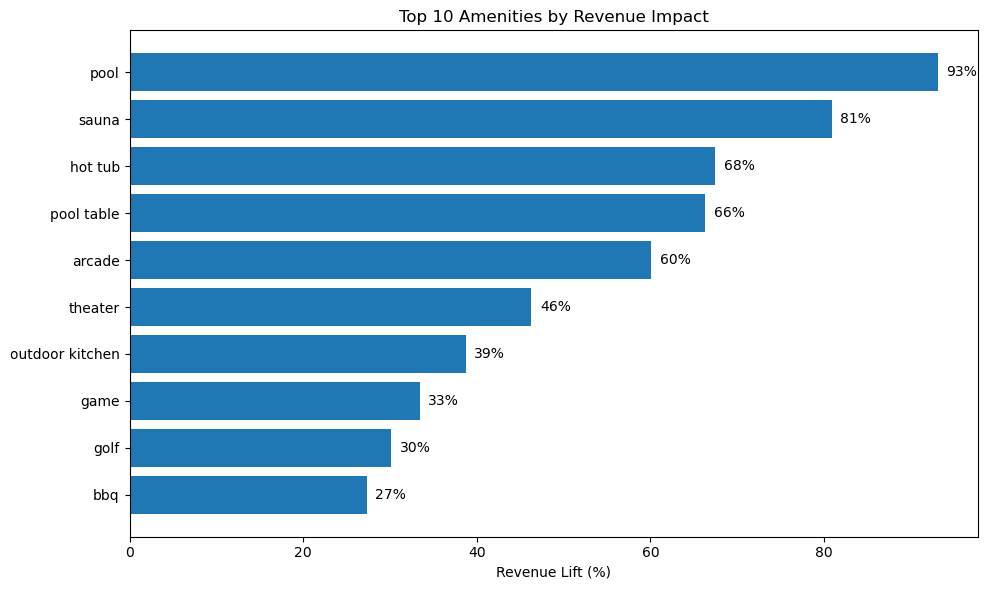

In [30]:
# Top 10 Amenities by Revenue Lift
top_10 = amenity_df.head(10)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(top_10['amenity'], top_10['pct_lift'])
ax.set_xlabel('Revenue Lift (%)')
ax.set_title('Top 10 Amenities by Revenue Impact')
ax.invert_yaxis()  # Highest at top

# Add percentage labels
for bar, pct in zip(bars, top_10['pct_lift']):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
            f'{pct:.0f}%', va='center')

plt.tight_layout()
plt.savefig('amenity_impact.png')
plt.show()

## Section 7: Hotel Price Scraping

In [32]:
# Check if requests is available
import requests

# Test a simple request
response = requests.get('https://www.google.com')
print(f"Request test: {response.status_code}")

Request test: 200


In [33]:
# Hotel API setup
import requests

API_KEY = "2954913e60msh6129ed85be60953p190854jsnd23701a237d3"
API_HOST = "booking-com15.p.rapidapi.com"

headers = {
    "X-RapidAPI-Key": API_KEY,
    "X-RapidAPI-Host": API_HOST
}

# Step 1: Get Las Vegas destination ID
url = "https://booking-com15.p.rapidapi.com/api/v1/hotels/searchDestination"
params = {"query": "Las Vegas"}

response = requests.get(url, headers=headers, params=params)
data = response.json()

print("Las Vegas destination info:")
print(data)

Las Vegas destination info:
{'status': True, 'message': 'Success', 'timestamp': 1769804702534, 'data': [{'dest_id': '1704', 'search_type': 'district', 'longitude': -115.16809, 'nr_hotels': 420, 'type': 'di', 'city_name': 'Las Vegas', 'lc': 'en', 'dest_type': 'district', 'hotels': 420, 'name': 'Las Vegas Strip', 'cc1': 'us', 'city_ufi': 20079110, 'country': 'United States', 'region': 'Nevada', 'latitude': 36.11722, 'image_url': 'https://cf.bstatic.com/xdata/images/district/150x150/57748.jpg?k=51747deca3a629656d48bf1dd783fe8d0303f270bb588d1a71a5763a14981fc8&o=', 'label': 'Las Vegas Strip, Las Vegas, Nevada, United States', 'roundtrip': 'GhA2YWIwOGY4ZjE1OWYwNGVmIAAoATICZW46CUxhcyBWZWdhc0AASgBQAA=='}, {'dest_id': '20079110', 'search_type': 'city', 'image_url': 'https://cf.bstatic.com/xdata/images/city/150x150/977408.jpg?k=125215335ffab346e954ff91ddbf6e4d2f15812d3e3a51b654ccd29705cce852&o=', 'region': 'Nevada', 'latitude': 36.119, 'country': 'United States', 'city_ufi': None, 'roundtrip': '

In [34]:
# Step 2: Search for hotels in Las Vegas
from datetime import datetime, timedelta

# Set dates (1 month from now, 1 night stay)
checkin = (datetime.now() + timedelta(days=30)).strftime('%Y-%m-%d')
checkout = (datetime.now() + timedelta(days=31)).strftime('%Y-%m-%d')

url = "https://booking-com15.p.rapidapi.com/api/v1/hotels/searchHotels"
params = {
    "dest_id": "1704",
    "search_type": "district",
    "arrival_date": checkin,
    "departure_date": checkout,
    "adults": 2,
    "room_qty": 1,
    "currency_code": "USD"
}

response = requests.get(url, headers=headers, params=params)
hotel_data = response.json()

print(f"Search dates: {checkin} to {checkout}")
print(f"Status: {hotel_data.get('status')}")
print(f"Number of results: {len(hotel_data.get('data', {}).get('hotels', []))}")

Search dates: 2026-03-01 to 2026-03-02
Status: True
Number of results: 20


In [35]:
# Get hotel prices across multiple dates over 3 months
from datetime import datetime, timedelta
import time

# Generate date ranges: 4 full weeks + 4 weekends over next 3 months
date_ranges = []

# Full weeks (Mon-Sun, 7 nights)
for weeks_out in [2, 6, 10, 14]:  # Spread across 3 months
    start = datetime.now() + timedelta(weeks=weeks_out)
    # Adjust to Monday
    start = start - timedelta(days=start.weekday())
    end = start + timedelta(days=7)
    date_ranges.append({
        'type': 'full_week',
        'checkin': start.strftime('%Y-%m-%d'),
        'checkout': end.strftime('%Y-%m-%d'),
        'nights': 7
    })

# Weekends (Fri-Sun, 2 nights)
for weeks_out in [3, 7, 11, 15]:
    start = datetime.now() + timedelta(weeks=weeks_out)
    # Adjust to Friday
    start = start + timedelta(days=(4 - start.weekday()) % 7)
    end = start + timedelta(days=2)
    date_ranges.append({
        'type': 'weekend',
        'checkin': start.strftime('%Y-%m-%d'),
        'checkout': end.strftime('%Y-%m-%d'),
        'nights': 2
    })

print(f"Searching {len(date_ranges)} date ranges:\n")
for dr in date_ranges:
    print(f"  {dr['type']:<10} {dr['checkin']} to {dr['checkout']} ({dr['nights']} nights)")

Searching 8 date ranges:

  full_week  2026-02-09 to 2026-02-16 (7 nights)
  full_week  2026-03-09 to 2026-03-16 (7 nights)
  full_week  2026-04-06 to 2026-04-13 (7 nights)
  full_week  2026-05-04 to 2026-05-11 (7 nights)
  weekend    2026-02-20 to 2026-02-22 (2 nights)
  weekend    2026-03-20 to 2026-03-22 (2 nights)
  weekend    2026-04-17 to 2026-04-19 (2 nights)
  weekend    2026-05-15 to 2026-05-17 (2 nights)


In [36]:
# Fetch hotel prices for each date range
all_results = []

for dr in date_ranges:
    print(f"Fetching {dr['type']} {dr['checkin']}...", end=" ")
    
    params = {
        "dest_id": "1704",
        "search_type": "district",
        "arrival_date": dr['checkin'],
        "departure_date": dr['checkout'],
        "adults": 2,
        "room_qty": 1,
        "currency_code": "USD"
    }
    
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    
    hotels = data.get('data', {}).get('hotels', [])
    
    for hotel in hotels:
        name = hotel.get('property', {}).get('name', 'Unknown')
        total_price = hotel.get('property', {}).get('priceBreakdown', {}).get('grossPrice', {}).get('value', 0)
        nightly_rate = total_price / dr['nights'] if dr['nights'] > 0 else 0
        
        all_results.append({
            'hotel': name,
            'date_type': dr['type'],
            'checkin': dr['checkin'],
            'nights': dr['nights'],
            'total_price': total_price,
            'nightly_rate': nightly_rate
        })
    
    print(f"{len(hotels)} hotels")
    time.sleep(1)  # Be nice to the API

print(f"\nTotal records collected: {len(all_results)}")

Fetching full_week 2026-02-09... 20 hotels
Fetching full_week 2026-03-09... 20 hotels
Fetching full_week 2026-04-06... 20 hotels
Fetching full_week 2026-05-04... 20 hotels
Fetching weekend 2026-02-20... 20 hotels
Fetching weekend 2026-03-20... 20 hotels
Fetching weekend 2026-04-17... 20 hotels
Fetching weekend 2026-05-15... 20 hotels

Total records collected: 160


In [37]:
# Convert to dataframe and analyze
hotel_df = pd.DataFrame(all_results)

# Save to database
hotel_df.to_sql('hotels', conn, index=False, if_exists='replace')
print("Table created: hotels\n")

# Summary stats
print("=" * 50)
print("HOTEL PRICE SUMMARY (Las Vegas Strip)")
print("=" * 50)

print(f"\nOverall average nightly rate: ${hotel_df['nightly_rate'].mean():,.0f}")
print(f"Median nightly rate: ${hotel_df['nightly_rate'].median():,.0f}")
print(f"Min: ${hotel_df['nightly_rate'].min():,.0f}")
print(f"Max: ${hotel_df['nightly_rate'].max():,.0f}")

print(f"\nBy date type:")
print(hotel_df.groupby('date_type')['nightly_rate'].mean().round(0))

Table created: hotels

HOTEL PRICE SUMMARY (Las Vegas Strip)

Overall average nightly rate: $327
Median nightly rate: $304
Min: $74
Max: $954

By date type:
date_type
full_week    252.0
weekend      402.0
Name: nightly_rate, dtype: float64


In [38]:
# Compare Hotel vs Airbnb prices
print("=" * 60)
print("HOTEL vs AIRBNB COMPARISON")
print("=" * 60)

# Hotel average
hotel_avg = hotel_df['nightly_rate'].mean()
hotel_median = hotel_df['nightly_rate'].median()

# Airbnb by room type (from our clean data)
airbnb_prices = listings_full.groupby('room_type')['price_clean'].agg(['mean', 'median']).round(0)

print(f"\n{'Option':<25} {'Avg Price':>12} {'Median':>12}")
print("-" * 50)
print(f"{'Hotel Room':<25} ${hotel_avg:>10,.0f} ${hotel_median:>10,.0f}")

for room_type in airbnb_prices.index:
    avg = airbnb_prices.loc[room_type, 'mean']
    med = airbnb_prices.loc[room_type, 'median']
    print(f"{room_type:<25} ${avg:>10,.0f} ${med:>10,.0f}")

HOTEL vs AIRBNB COMPARISON

Option                       Avg Price       Median
--------------------------------------------------
Hotel Room                $       327 $       304
Entire home/apt           $       203 $       162
Hotel room                $       200 $       151
Private room              $       122 $        63
Shared room               $        54 $        25


In [39]:
# Check what hotel data we captured
print("Sample hotel record:")
print(hotel_data['data']['hotels'][0])

Sample hotel record:
{'hotel_id': 10685668, 'accessibilityLabel': 'LUXE 702 MGM Signature with Balcony.\n3 out of 5 for property rating.\nThis is a Preferred property.\n8.2 Very good 14 reviews.\n\u200eIn city centre\u202c.\nLimited-time Deal.\n Private suite – 84\xa0m² : 3\xa0beds • 1\xa0bedroom • 1\xa0living room • 2\xa0bathrooms.\nOriginal price 476 USD. Current price 408 USD..\nIncludes taxes and charges.\nOnly 1 left at this price on Booking.com.', 'property': {'reviewScore': 8.2, 'checkoutDate': '2026-03-02', 'reviewScoreWord': 'Very good', 'id': 10685668, 'rankingPosition': 0, 'reviewCount': 14, 'mainPhotoId': 497257889, 'countryCode': 'us', 'accuratePropertyClass': 0, 'ufi': 20079110, 'photoUrls': ['https://cf.bstatic.com/xdata/images/hotel/square500/497257889.jpg?k=80b40eca2e7210b8b1072a2aca82041aff35688a49321d90762cbb0a247d9770&o=', 'https://cf.bstatic.com/xdata/images/hotel/square1024/497257889.jpg?k=80b40eca2e7210b8b1072a2aca82041aff35688a49321d90762cbb0a247d9770&o=', 'http

In [40]:
# Re-fetch with full details
all_results = []

for dr in date_ranges:
    print(f"Fetching {dr['type']} {dr['checkin']}...", end=" ")
    
    params = {
        "dest_id": "1704",
        "search_type": "district",
        "arrival_date": dr['checkin'],
        "departure_date": dr['checkout'],
        "adults": 2,
        "room_qty": 1,
        "currency_code": "USD"
    }
    
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    
    hotels = data.get('data', {}).get('hotels', [])
    
    for hotel in hotels:
        prop = hotel.get('property', {})
        label = hotel.get('accessibilityLabel', '')
        
        total_price = prop.get('priceBreakdown', {}).get('grossPrice', {}).get('value', 0)
        nightly_rate = total_price / dr['nights'] if dr['nights'] > 0 else 0
        
        all_results.append({
            'hotel': prop.get('name', 'Unknown'),
            'stars': prop.get('accuratePropertyClass', 0),
            'review_score': prop.get('reviewScore', 0),
            'review_count': prop.get('reviewCount', 0),
            'room_details': label,
            'date_type': dr['type'],
            'checkin': dr['checkin'],
            'nights': dr['nights'],
            'total_price': total_price,
            'nightly_rate': nightly_rate
        })
    
    print(f"{len(hotels)} hotels")
    time.sleep(1)

hotel_df = pd.DataFrame(all_results)
print(f"\nTotal records: {len(hotel_df)}")

Fetching full_week 2026-02-09... 20 hotels
Fetching full_week 2026-03-09... 20 hotels
Fetching full_week 2026-04-06... 0 hotels
Fetching full_week 2026-05-04... 0 hotels
Fetching weekend 2026-02-20... 0 hotels
Fetching weekend 2026-03-20... 0 hotels
Fetching weekend 2026-04-17... 0 hotels
Fetching weekend 2026-05-15... 0 hotels

Total records: 40


In [41]:
# Analyze hotel prices by star rating
print("=" * 60)
print("HOTEL PRICES BY STAR RATING")
print("=" * 60)

star_analysis = hotel_df.groupby('stars').agg({
    'nightly_rate': ['mean', 'median', 'count'],
    'review_score': 'mean'
}).round(0)

star_analysis.columns = ['avg_rate', 'median_rate', 'count', 'avg_review']
print(star_analysis)

HOTEL PRICES BY STAR RATING
       avg_rate  median_rate  count  avg_review
stars                                          
0         277.0        277.0      2         8.0
3         166.0        171.0     15         8.0
4         264.0        265.0     13         8.0
5         445.0        470.0     10         9.0


In [42]:
# Check room details for kitchenette/kitchen mentions
hotel_df['has_kitchen'] = hotel_df['room_details'].str.lower().str.contains('kitchen', na=False)
hotel_df['has_studio'] = hotel_df['room_details'].str.lower().str.contains('studio', na=False)
hotel_df['has_suite'] = hotel_df['room_details'].str.lower().str.contains('suite', na=False)

print("Room types found:")
print(f"  With kitchen/kitchenette: {hotel_df['has_kitchen'].sum()}")
print(f"  Studios: {hotel_df['has_studio'].sum()}")
print(f"  Suites: {hotel_df['has_suite'].sum()}")

print("\nPrice comparison - rooms with kitchen vs without:")
print(hotel_df.groupby('has_kitchen')['nightly_rate'].median().round(0))

Room types found:
  With kitchen/kitchenette: 0
  Studios: 0
  Suites: 5

Price comparison - rooms with kitchen vs without:
has_kitchen
False    252.0
Name: nightly_rate, dtype: float64


In [43]:
# Compare hotels by star rating to top Airbnb performers
print("=" * 70)
print("HOTEL vs TOP AIRBNB COMPARISON (Median Nightly Rate)")
print("=" * 70)

# Hotel medians by stars
hotel_3star = hotel_df[hotel_df['stars'] == 3]['nightly_rate'].median()
hotel_4star = hotel_df[hotel_df['stars'] == 4]['nightly_rate'].median()
hotel_5star = hotel_df[hotel_df['stars'] == 5]['nightly_rate'].median()

# Airbnb percentiles (entire homes, Unincorporated Areas)
airbnb_filtered = listings_full[
    (listings_full['neighbourhood_cleansed'] == 'Unincorporated Areas') &
    (listings_full['room_type'] == 'Entire home/apt')
]

airbnb_median = airbnb_filtered['price_clean'].median()
airbnb_75th = airbnb_filtered['price_clean'].quantile(0.75)
airbnb_90th = airbnb_filtered['price_clean'].quantile(0.90)

print(f"\n{'Option':<35} {'Nightly Rate':>15} {'Kitchen':>10}")
print("-" * 62)
print(f"{'3-Star Hotel':<35} ${hotel_3star:>13,.0f} {'No':>10}")
print(f"{'4-Star Hotel':<35} ${hotel_4star:>13,.0f} {'No':>10}")
print(f"{'5-Star Hotel':<35} ${hotel_5star:>13,.0f} {'No':>10}")
print("-" * 62)
print(f"{'Airbnb Entire Home (Median)':<35} ${airbnb_median:>13,.0f} {'Yes':>10}")
print(f"{'Airbnb Entire Home (75th %)':<35} ${airbnb_75th:>13,.0f} {'Yes':>10}")
print(f"{'Airbnb Entire Home (90th %)':<35} ${airbnb_90th:>13,.0f} {'Yes':>10}")

HOTEL vs TOP AIRBNB COMPARISON (Median Nightly Rate)

Option                                 Nightly Rate    Kitchen
--------------------------------------------------------------
3-Star Hotel                        $          171         No
4-Star Hotel                        $          265         No
5-Star Hotel                        $          470         No
--------------------------------------------------------------
Airbnb Entire Home (Median)         $          163        Yes
Airbnb Entire Home (75th %)         $          249        Yes
Airbnb Entire Home (90th %)         $          389        Yes


In [44]:
# Save updated hotel data to database
hotel_df.to_sql('hotels', conn, index=False, if_exists='replace')
print("Table updated: hotels")

# Create comparison dataframe for visualization
comparison = pd.DataFrame({
    'option': ['3-Star Hotel', '4-Star Hotel', '5-Star Hotel', 
               'Airbnb (Median)', 'Airbnb (75th %)', 'Airbnb (90th %)'],
    'nightly_rate': [hotel_3star, hotel_4star, hotel_5star,
                     airbnb_median, airbnb_75th, airbnb_90th],
    'type': ['Hotel', 'Hotel', 'Hotel', 'Airbnb', 'Airbnb', 'Airbnb']
})

comparison.to_sql('hotel_vs_airbnb', conn, index=False, if_exists='replace')
print("Table created: hotel_vs_airbnb")

Table updated: hotels
Table created: hotel_vs_airbnb


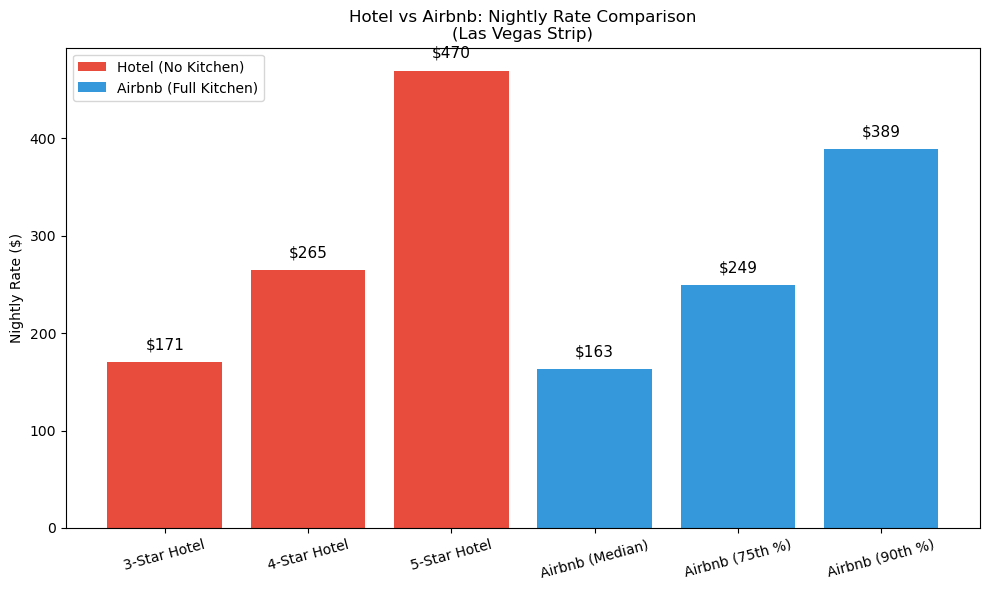

In [45]:
# Hotel vs Airbnb Comparison Chart
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#e74c3c', '#e74c3c', '#e74c3c', '#3498db', '#3498db', '#3498db']

bars = ax.bar(comparison['option'], comparison['nightly_rate'], color=colors)

ax.set_ylabel('Nightly Rate ($)')
ax.set_title('Hotel vs Airbnb: Nightly Rate Comparison\n(Las Vegas Strip)')
ax.tick_params(axis='x', rotation=15)

# Add price labels
for bar, price in zip(bars, comparison['nightly_rate']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            f'${price:.0f}', ha='center', va='bottom', fontsize=11)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#e74c3c', label='Hotel (No Kitchen)'),
                   Patch(facecolor='#3498db', label='Airbnb (Full Kitchen)')]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

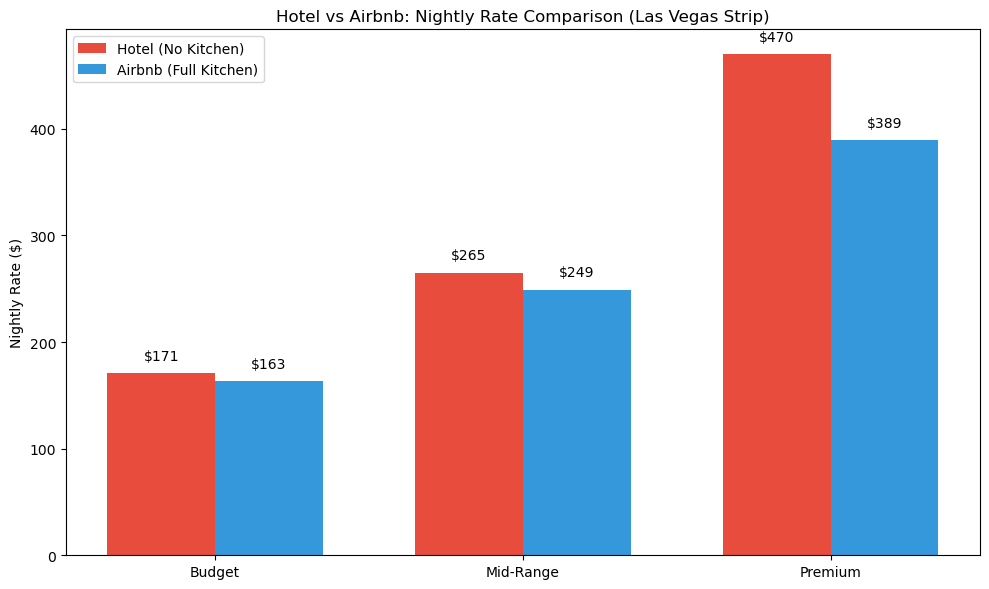

In [46]:
# Side by side comparison chart
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Budget', 'Mid-Range', 'Premium']
hotel_prices = [hotel_3star, hotel_4star, hotel_5star]
airbnb_prices = [airbnb_median, airbnb_75th, airbnb_90th]

x = range(len(categories))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], hotel_prices, width, label='Hotel (No Kitchen)', color='#e74c3c')
bars2 = ax.bar([i + width/2 for i in x], airbnb_prices, width, label='Airbnb (Full Kitchen)', color='#3498db')

ax.set_ylabel('Nightly Rate ($)')
ax.set_title('Hotel vs Airbnb: Nightly Rate Comparison (Las Vegas Strip)')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Add price labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            f'${bar.get_height():.0f}', ha='center', va='bottom')

for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            f'${bar.get_height():.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('hotel_vs_airbnb.png')
plt.show()

## Section 8: Final Output - Investment Recommendations

In [48]:
# Final Investment Recommendation Summary
print("=" * 70)
print("LAS VEGAS SHORT-TERM RENTAL INVESTMENT ANALYSIS")
print("=" * 70)

print("\n📊 DATA SUMMARY:")
print(f"   Airbnb listings analyzed: {len(listings_full):,}")
print(f"   MLS home sales analyzed: {len(mls):,}")
print(f"   Hotel rates analyzed: {len(hotel_df):,}")

print("\n" + "=" * 70)
print("🏆 TOP INVESTMENT OPPORTUNITIES (by ROI)")
print("=" * 70)
print(roi_analysis[['bedrooms', 'home_price', 'revenue_75th', 'net_income_75th', 'roi_75th', 'revenue_90th', 'net_income_90th', 'roi_90th']].to_string(index=False))

print("\n" + "=" * 70)
print("🏠 KEY AMENITIES THAT DRIVE REVENUE")
print("=" * 70)
top_5_amenities = amenity_df.head(5)[['amenity', 'pct_lift', 'revenue_with']]
print(top_5_amenities.to_string(index=False))

print("\n" + "=" * 70)
print("🏨 AIRBNB vs HOTEL (Guest Value Proposition)")
print("=" * 70)
print(f"   {'Tier':<15} {'Hotel':>12} {'Airbnb':>12} {'Savings':>12}")
print(f"   {'-'*51}")
print(f"   {'Budget':<15} ${hotel_3star:>10,.0f} ${airbnb_median:>10,.0f} ${hotel_3star - airbnb_median:>10,.0f}")
print(f"   {'Mid-Range':<15} ${hotel_4star:>10,.0f} ${airbnb_75th:>10,.0f} ${hotel_4star - airbnb_75th:>10,.0f}")
print(f"   {'Premium':<15} ${hotel_5star:>10,.0f} ${airbnb_90th:>10,.0f} ${hotel_5star - airbnb_90th:>10,.0f}")

LAS VEGAS SHORT-TERM RENTAL INVESTMENT ANALYSIS

📊 DATA SUMMARY:
   Airbnb listings analyzed: 11,833
   MLS home sales analyzed: 2,990
   Hotel rates analyzed: 40

🏆 TOP INVESTMENT OPPORTUNITIES (by ROI)
 bedrooms  home_price  revenue_75th  net_income_75th  roi_75th  revenue_90th  net_income_90th  roi_90th
      2.0    361188.0       50322.0          28650.0      7.93       86625.0          64954.0     17.98
      6.0    667422.0       92225.0          52180.0      7.82      148000.0         107955.0     16.17
      5.0    524622.0       65182.0          33705.0      6.42      107831.0          76353.0     14.55
      1.0    277504.0       27664.0          11014.0      3.97       54612.0          37962.0     13.68
      4.0    425455.0       50946.0          25418.0      5.97       73412.0          47885.0     11.25
      3.0    403568.0       42685.0          18471.0      4.58       66386.0          42172.0     10.45

🏠 KEY AMENITIES THAT DRIVE REVENUE
   amenity  pct_lift  revenue_wi

In [49]:
# Final Recommendations
print("=" * 70)
print("✅ INVESTMENT RECOMMENDATIONS")
print("=" * 70)

print("""
BEST BETS (High ROI + Reliable Data):

1. 🥇 2-BEDROOM in Unincorporated Areas (Las Vegas Strip)
   - Home Price: ~$361K
   - Expected Revenue: $50K - $87K/year (75th-90th percentile)
   - ROI: 7.9% - 18.0%
   - Why: Best ROI, most liquid market, strong data (1,626 listings)

2. 🥈 5-BEDROOM in Unincorporated Areas
   - Home Price: ~$525K
   - Expected Revenue: $65K - $108K/year
   - ROI: 6.4% - 14.6%
   - Why: Higher cash flow, good for groups/events

3. 🥉 6-BEDROOM in Unincorporated Areas
   - Home Price: ~$667K
   - Expected Revenue: $92K - $148K/year
   - ROI: 7.8% - 16.2%
   - Why: Highest total income, premium market

MUST-HAVE AMENITIES (in order of impact):
   1. Pool (+93% revenue lift)
   2. Sauna (+81%)
   3. Hot tub (+68%)
   4. Pool table (+66%)
   5. Arcade (+60%)

GUEST VALUE PROPOSITION:
   - Airbnb offers $20-$164 savings vs comparable hotels
   - Plus: Full kitchen, more space, private amenities
   - Target: Families, groups, extended stays
""")

✅ INVESTMENT RECOMMENDATIONS

BEST BETS (High ROI + Reliable Data):

1. 🥇 2-BEDROOM in Unincorporated Areas (Las Vegas Strip)
   - Home Price: ~$361K
   - Expected Revenue: $50K - $87K/year (75th-90th percentile)
   - ROI: 7.9% - 18.0%
   - Why: Best ROI, most liquid market, strong data (1,626 listings)

2. 🥈 5-BEDROOM in Unincorporated Areas
   - Home Price: ~$525K
   - Expected Revenue: $65K - $108K/year
   - ROI: 6.4% - 14.6%
   - Why: Higher cash flow, good for groups/events

3. 🥉 6-BEDROOM in Unincorporated Areas
   - Home Price: ~$667K
   - Expected Revenue: $92K - $148K/year
   - ROI: 7.8% - 16.2%
   - Why: Highest total income, premium market

MUST-HAVE AMENITIES (in order of impact):
   1. Pool (+93% revenue lift)
   2. Sauna (+81%)
   3. Hot tub (+68%)
   4. Pool table (+66%)
   5. Arcade (+60%)

GUEST VALUE PROPOSITION:
   - Airbnb offers $20-$164 savings vs comparable hotels
   - Plus: Full kitchen, more space, private amenities
   - Target: Families, groups, extended stays

In [50]:
# Save and close database connection
conn.commit()

# Show all tables in database
query = "SELECT name FROM sqlite_master WHERE type='table'"
tables = pd.read_sql(query, conn)

print("=" * 70)
print("💾 DATABASE SAVED: vegas_airbnb.db")
print("=" * 70)
print("\nTables available for future analysis:")
for table in tables['name']:
    count = pd.read_sql(f"SELECT COUNT(*) as n FROM {table}", conn).iloc[0, 0]
    print(f"   - {table}: {count:,} rows")

💾 DATABASE SAVED: vegas_airbnb.db

Tables available for future analysis:
   - listings: 11,833 rows
   - mls: 2,990 rows
   - neighbourhoods: 7 rows
   - top_performers: 6 rows
   - amenity_impact: 15 rows
   - hotels: 40 rows
   - hotel_vs_airbnb: 6 rows


In [51]:
# Export clean data for Streamlit app
listings_full.to_csv('listings_clean.csv', index=False)
mls.to_csv('mls_data.csv', index=False)